In [1]:
from bencodepy import decode
from enum import Enum
from hashlib import sha1, sha256
from os import scandir
from time import monotonic
class Type(Enum):
    UNDEF = 0,
    V1 = 1,
    V2 = 2,
    HYBRID = 3
class Torrent():
    def __init__(self):
        self.sha1 = b''
        self.files = {}
        self.type = Type.UNDEF
    def file(self, f):
        self.parse(open(f, "rb").read())
    def parse(self, b):
        infodict = b[b.find(b'4:info')+6:b.rfind(b'6:sourced2:ip')]
        self.sha1 = sha1(infodict).digest()
        self.sha256 = sha256(infodict).digest()
        self.dict = decode(b)
        if b'pieces' in self.dict.get(b'info'):
            self.dict.get(b'info').pop(b'pieces')
        if b'files' in self.dict.get(b'info').keys():
            self.type = Type.V1
            for file in self.dict.get(b'info').get(b'files'):
                if file.get(b'attr') is not None and b'p' in file.get(b'attr') or b'padding.file' in b'/'.join(file.get(b'path')) or b'.pad' in file.get(b'path'):
                    continue
                def insert_file(d, path, length, self):
                    name = path.pop()
                    if not len(path):
                        d[name] = length
                        return
                    if name not in d.keys():
                        d[name] = {}
                    insert_file(d[name], path, length, self)
                file.get(b'path').reverse()
                insert_file(self.files, file.get(b'path'), file.get(b'length'), self)
            self.dict.get(b'info').pop(b'files')
        if b'file tree' in self.dict.get(b'info').keys(): # some torrents have broken file trees so we use files first
            if self.type is Type.V1:
                self.type = Type.HYBRID
            else:
                def filetree(names):
                    r = {}
                    for key in names.keys():
                        if key == b'':
                            return names.get(key).get(b'length')
                        r[key] = filetree(names.get(key))
                    return r
                self.files = filetree(self.dict.get(b'info').get(b'file tree'))
                self.dict.get(b'info').pop(b'file tree')
        if not len(self.files):
            self.type = Type.V1
            self.files[self.dict.get(b'info').get(b'name')] = self.dict.get(b'info').get(b'length')
        first_filename = [i for i in self.files.keys()][0]
        if len(self.files) == 1 and self.files[first_filename] == {}:
            print("fixed bad single file torrent", self.sha1.hex())
            self.files[first_filename] = self.dict.get(b'info').get(b'length')
    def paths(self):
        def paths_r(d, path=None):
            if path is None:
                path = []
            for f in d.keys():
                if type(d[f]) is int:
                    z = path.copy()
                    z.append(f)
                    yield z, d[f]
                else:
                    z = path.copy()
                    z.append(f)
                    for z, v in paths_r(d[f], z):
                        yield z, v
        for z, v in paths_r(self.files):
            yield z, v
    def __repr__(self):
        return str(self.__dict__)
    def __hash__(self):
        if len(self.sha1):
            return int.from_bytes(self.sha1, byteorder="big")
        return id(self)
def glob(d):
    r = {}
    for f in scandir(d):
        if f.name.endswith(".torrent") and f.is_file():
            t = Torrent()
            t.file(f.path)
            r[t.sha1] = t
    return r
print("......")
start = monotonic()
torrents = glob("/root/projects/travnik")
print(len(torrents), "@", monotonic()-start, "s")
# t = Torrent()
# t.file("/root/projects/travnik/449a38ef7e042bd2d75e8921aa02f6f244165d9d.torrent")
# print(t.sha1.hex())
# for path, length in t.paths():
#     print(path, length)
# print(t)

......
fixed bad single file torrent 4f269d8aefd647ee270842d53ec98aebd23a4afe
fixed bad single file torrent 7b09ae0b612dafc1744562dccbbe4becf4d633c3
37769 @ 434.7589800900314 s


<IPython.core.display.Javascript object>


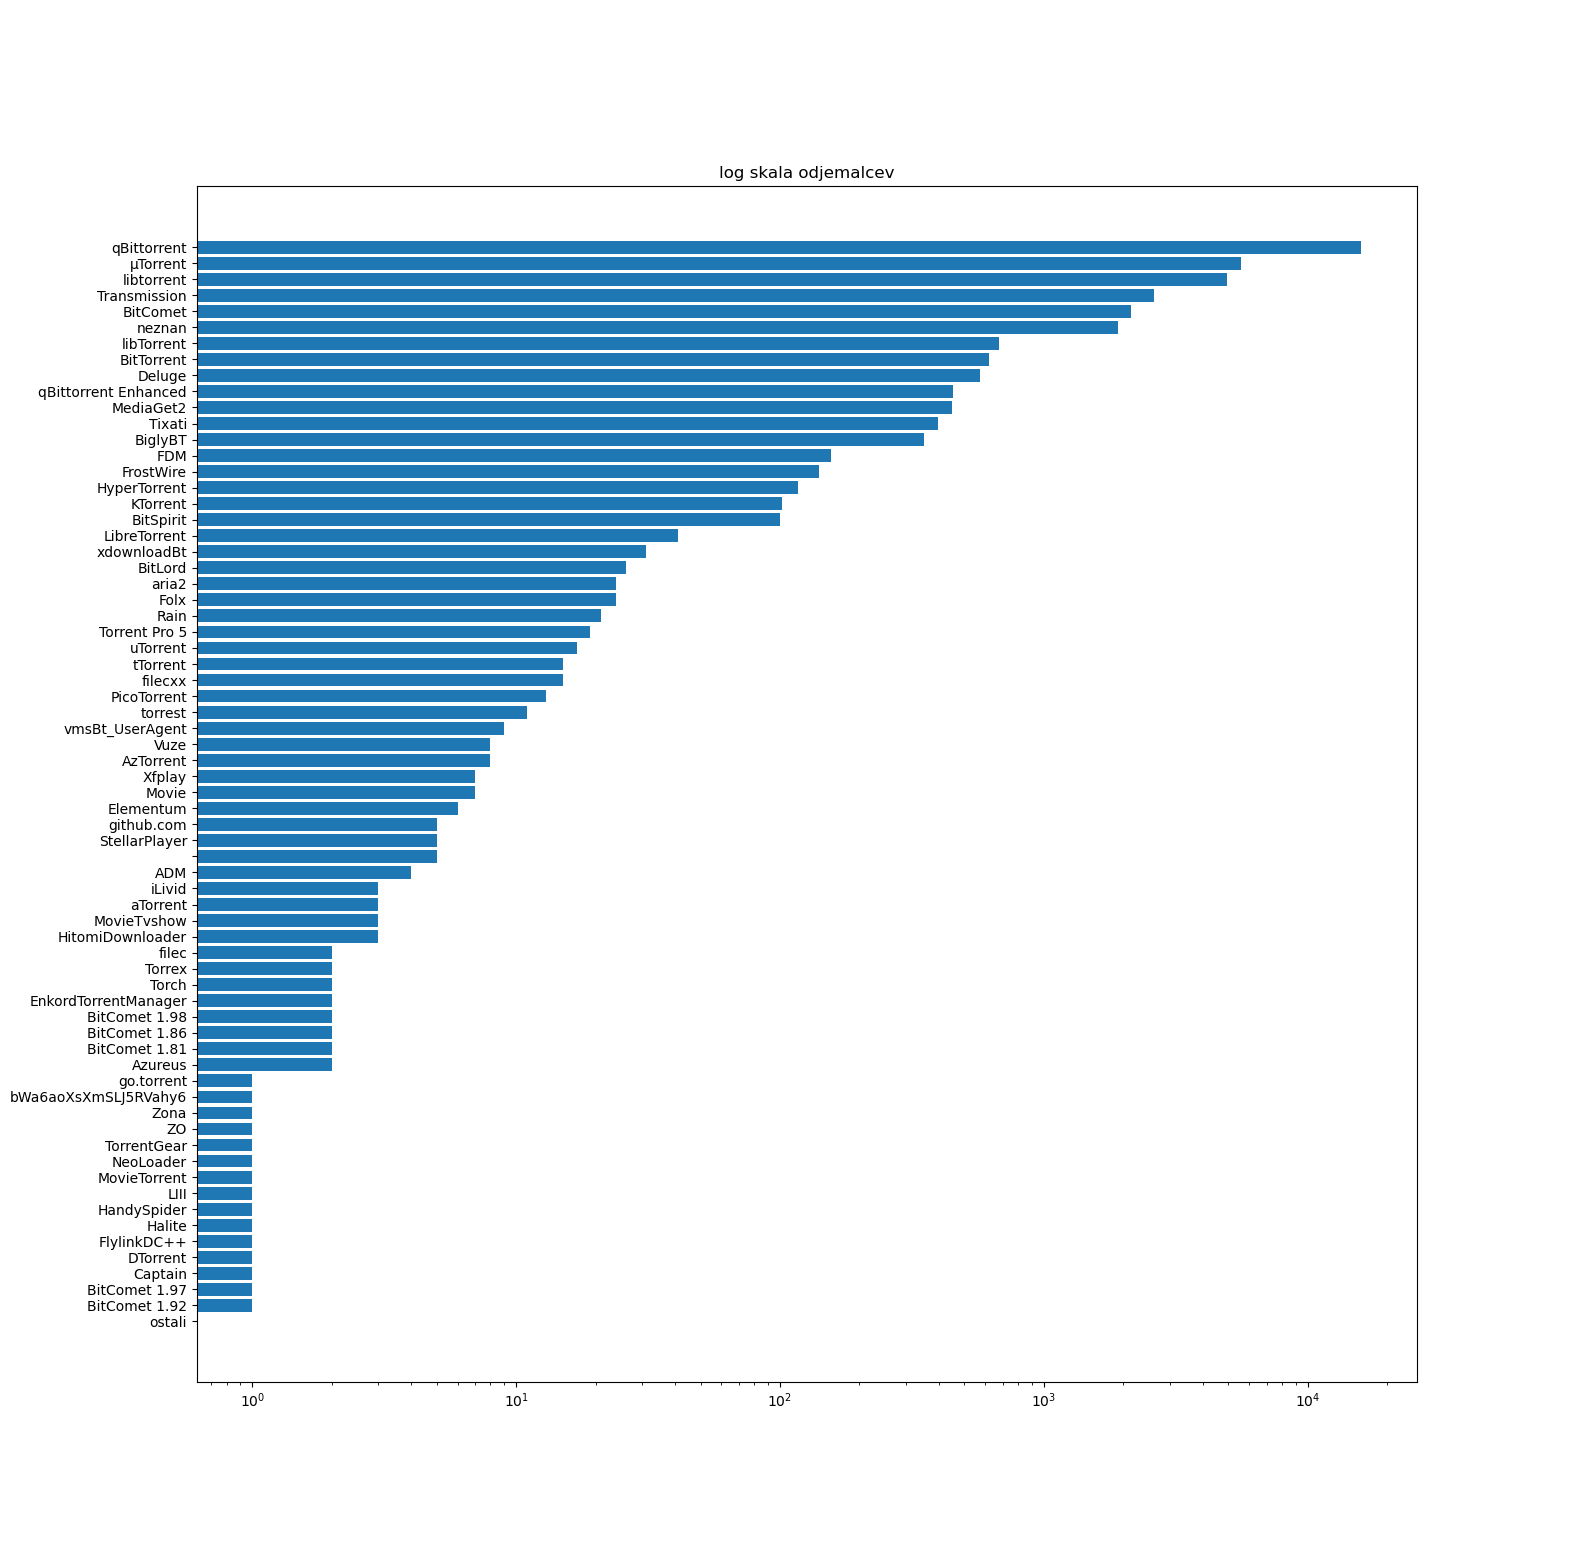

0.22313746600411832 za 67 različnih odjemalcev


In [30]:
s = monotonic()
def uas(normalize=True, minrepr=0):
    odjemalci = {}
    for sha1, torrent in torrents.items():
        odjemalec = torrent.dict.get(b'source').get(b'v')
        if normalize and odjemalec is not None:
            if b'/' in odjemalec:
                odjemalec = odjemalec.split(b'/')[0]
            elif b' (' in odjemalec:
                odjemalec = odjemalec.split(b' (')[0]
            else:
                odjemalec = odjemalec.split(b' ')[0]
            odjemalec = odjemalec.replace(b'\xc2\xb5', b'\xce\xbc').decode()
        if odjemalec not in odjemalci.keys():
            odjemalci[odjemalec] = 1
        else:
            odjemalci[odjemalec] += 1
    trueodj = {"ostali": 0}
    count = 0
    for key, value in odjemalci.items():
        count += 1
        if value < minrepr:
            trueodj["ostali"] += value
        else:
            trueodj[key] = value
    trueodj = [(v, k) for k, v in trueodj.items()]
    return trueodj, count
odjemalci, count = uas(True, minrepr=0*len(torrents))
odjemalci = sorted(odjemalci, reverse=False)
from matplotlib import pyplot
%matplotlib notebook
fig, axes = pyplot.subplots()
from math import log
# axes.pie([log(sights) if sights else 0 for sights, name in odjemalci], labels=[name for sights, name in odjemalci])
axes.barh([name if name is not None else "neznan" for sights, name in odjemalci], [sights for sights, name in odjemalci])
axes.set_title("log skala odjemalcev")
pyplot.xscale("log")
fig.show()
print(monotonic()-s, "za", count, "različnih odjemalcev")

0.15033814194612205 s 40


<IPython.core.display.Javascript object>


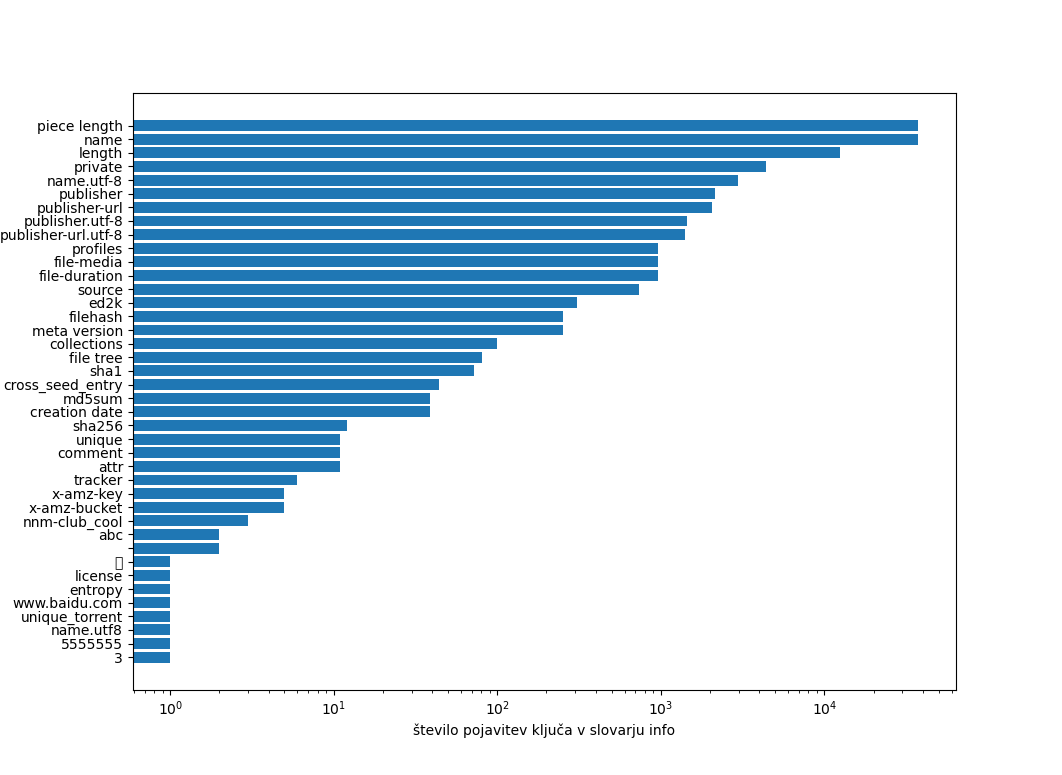

3 [1, '', '93f549c401bebe4f86ef23626e0fed3d06183b02']
5555555 [1, '555555555555555555', '93f549c401bebe4f86ef23626e0fed3d06183b02']
name.utf8 [1, 'Connections', 'a23296ce90328791cb6974cf6f6306da4dd89735']
unique_torrent [1, 1, '2c3ea79de0771079e41fc25f4cabf23e11041829']
www.baidu.com [1, 'www.baidu.com', '43b238596c66575e7dfcd4d5b1d0fadb6c393adc']
entropy [1, 1460043970, '0635e6c7d348c2603501e9fa53e4cf07f9e31b5e']
license [1, OrderedDict([(b'creative-commons', OrderedDict([(b'attributionAuthor', b'Dave Doobie Aaron'), (b'attributionTitle', b'Doobie'), (b'attributionUrl', b'http://fb.com/doobiebrooklyn'), (b'licenseUrl', b'http://creativecommons.org/licenses/by-nc/4.0/')]))]), '1d670c41fd340c8ee280157400744402740fc1fd']
还 [1, '百度', '647e1210953d6080f714f0f8dabffe6ee9852800']
 [2, 1, 'fa6fbc7d7796e49fbdf47731fe06a6e20ee74bb5']
abc [2, 'abc', '9c8047972d058dee41bab8ab68ad5da7c24275ed']
nnm-club_cool [3, 1, '57f6facb1bcef159b8075b578053fb4790e0c8d5']
x-amz-bucket [5, 'quranwave', '3af8e25c

In [31]:
s = monotonic()
keys = {}
for sha1, torrent in torrents.items():
    for key in torrent.dict.get(b'info').keys():
        if key.decode() not in keys.keys():
            value = torrent.dict.get(b'info').get(key)
            if type(value) is bytes:
                try:
                    value = value.decode()
                except UnicodeDecodeError:
                    pass
            keys[key.decode()] = [1, value, sha1.hex()]
        else:
            keys[key.decode()][0] += 1
sort = sorted(keys, key=lambda x: keys[x][0])
print(monotonic()-s, "s", len(keys))
%matplotlib notebook
fig, ax = pyplot.subplots();
ax.barh(sort, [keys[x][0] for x in sort])
pyplot.xscale("log")
pyplot.xlabel("število pojavitev ključa v slovarju info")
fig.show() ## TODO komentiraj
for i in sort:
    print(i, keys[i])

In [32]:
s = monotonic()
def sources():
    sources = {}
    for sha1, torrent in torrents.items():
        source = torrent.dict.get(b'info').get(b'source')
        if source is None:
            source = torrent.dict.get(b'info').get(b'publisher')
        if source is None:
            source = torrent.dict.get(b'info').get(b'publisher-url')
        try:
            if type(source) is bytes:
                source = source.decode().strip()
        except UnicodeDecodeError:
            pass
        if source not in sources.keys():
            sources[source] = 1
        else:
            sources[source] += 1
    return sources
sources = sources()
sort = sorted(sources, reverse=True, key=lambda x:sources[x])
sort.remove(None)
print(monotonic()-s, "s", sources[None]/len(torrents)*100, "brez ključa source, publisher ali publisher-url", len(sources), "virov")
from tabulate import tabulate
tabulate([[x, sources[x]] for x in sort], tablefmt="html")

0.07545290817506611 s 92.2872340425532 brez ključa source, publisher ali publisher-url 729 virov


'<table>\n<tbody>\n<tr><td>PMEDIA                                                                                                                                                                                                                                                                        </td><td style="text-align: right;">134</td></tr>\n<tr><td>http://tapochek.net/index.php                                                                                                                                                                                                                                                 </td><td style="text-align: right;">114</td></tr>\n<tr><td>高清下载吧！                                                                                                                                                                                                                                                                  </td><td style="text-align: right;"> 98</td></tr>\n<tr><td>https://FreeCourseWeb.com                                                                                                                                                                                                                                                     </td><td style="text-align: right;"> 91</td></tr>\n<tr><td>灣搭拉咩拉                                                                                                                                                                                                                                                                    </td><td style="text-align: right;"> 79</td></tr>\n<tr><td>脫拉庫                                                                                                                                                                                                                                                                        </td><td style="text-align: right;"> 69</td></tr>\n<tr><td>1024社區最新地址                                                                                                                                                                                                                                                              </td><td style="text-align: right;"> 68</td></tr>\n<tr><td>第一會所新片@SIS001                                                                                                                                                                                                                                                           </td><td style="text-align: right;"> 64</td></tr>\n<tr><td>大师兄福利网                                                                                                                                                                                                                                                                  </td><td style="text-align: right;"> 59</td></tr>\n<tr><td>2048                                                                                                                                                                                                                                                                          </td><td style="text-align: right;"> 56</td></tr>\n<tr><td>                                                                                                                                                                                                                                                                              </td><td style="text-align: right;"> 53</td></tr>\n<tr><td>LostFilm.TV                                                                                                                                                                                                                                                                   </td><td style="text-align: right;"> 50</td></tr>\n<tr><td>[https://tanhuazu.com] 探花族社区                             

In [2]:
s = monotonic()
def removeminorities(population, minrepr=0, ostalo="ostalo"):
    true = {ostalo: 0}
    for key, value in population.items():
        if value < minrepr:
            true[ostalo] += value
        else:
            true[key] = value
    return true
from mimetypes import guess_type
def ext(mime=False, minreprratio=0):
    bycount = {}
    bysize = {}
    bysizerepresentative = {}
    filescount = 0
    bytescount = 0
    for sha1, torrent in torrents.items():
        try:
            representatives = {}
            for path, size in torrent.paths():
                filescount += 1
                bytescount += size
                if mime:
                    ext = guess_type(path.pop().decode(encoding="iso-8859-2"))[0]
                else:
                    ext = path.pop().split(b'.').pop().decode(encoding="iso-8859-2").lower()
                if ext not in bycount.keys():
                    bycount[ext] = 1
                else:
                    bycount[ext] += 1
                if ext not in bysize.keys():
                    bysize[ext] = size
                else:
                    bysize[ext] += size
                if ext not in representatives.keys():
                    representatives[ext] = size
                else:
                    representatives[ext] += size
        except AttributeError:
            print(sha1.hex(), torrent)
            raise AttributeError
        try:
            representative = sorted(representatives, key=lambda x:representatives[x]).pop()
        except IndexError:
            print(sha1.hex(), torrent)
            raise IndexError
        if representative not in bysizerepresentative.keys():
            bysizerepresentative[representative] = 1
        else:
            bysizerepresentative[representative] += 1
    truebycount = removeminorities(bycount, minreprratio*filescount, "ostale")
    truebysize = removeminorities(bysize, minreprratio*bytescount, "ostale")
    truebysizerepresentative = removeminorities(bysizerepresentative, minreprratio*len(torrents), "ostale")
    for data in [truebycount, truebysize, truebysizerepresentative]:
        data = [(v, k) for k, v in data.items()]
    return truebycount, truebysize, truebysizerepresentative, len(bycount), filescount, bytescount
print("...")
bycount, bysize, bysizerepresentative, kinds, filescount, bytescount = ext(False, 0.0005)
print(monotonic()-s, "s", kinds, "različnih tipov v", filescount, "datotekah in", bytescount/(1024**4), "TiB")

...
8.8120769248344 s 284089 različnih tipov v 2515100 datotekah in 203.7606503055813 TiB


<IPython.core.display.Javascript object>


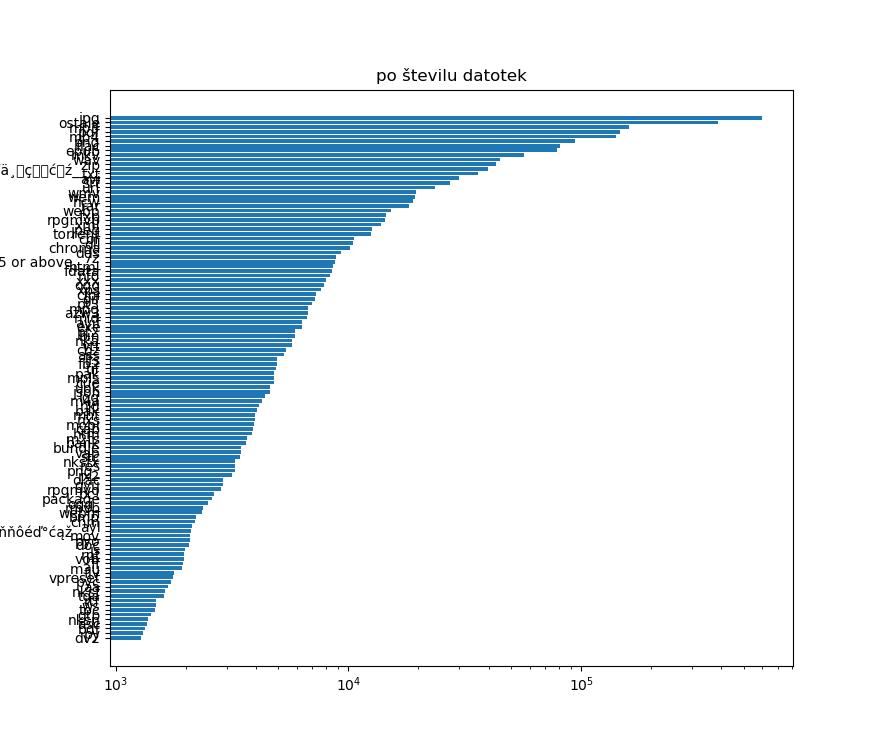

<IPython.core.display.Javascript object>


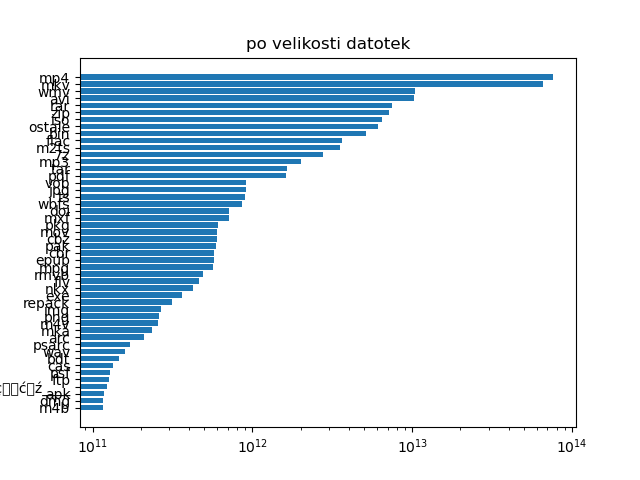

<IPython.core.display.Javascript object>


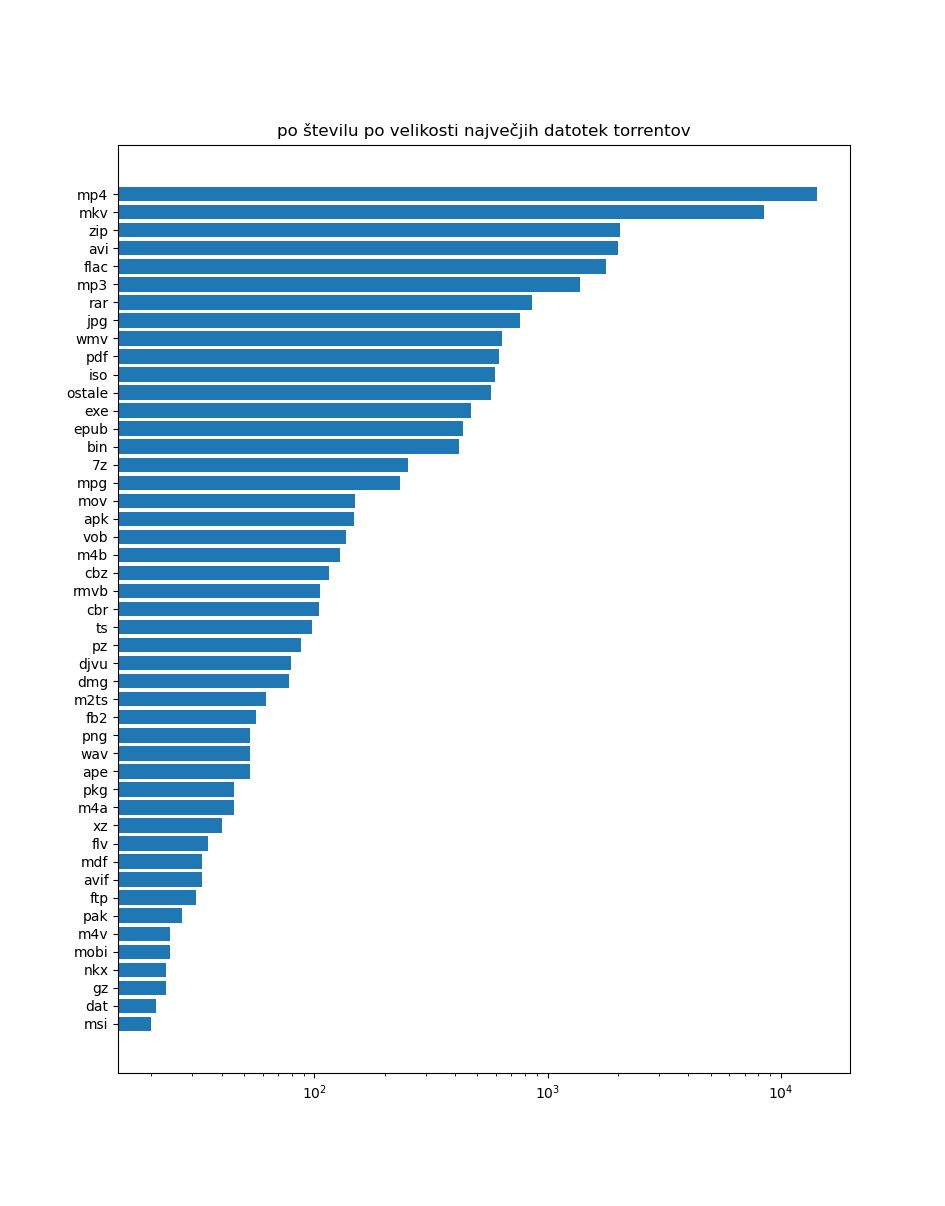

In [3]:
sortcount = sorted(bycount, reverse=False, key=lambda x: bycount[x])
sortsize = sorted(bysize, reverse=False, key=lambda x: bysize[x])
sortsizerepresentative = sorted(bysizerepresentative, reverse=False, key=lambda x: bysizerepresentative[x])
from matplotlib import pyplot
%matplotlib notebook
for desc, data in {"po številu datotek": (sortcount, bycount), "po velikosti datotek": (sortsize, bysize), "po številu po velikosti največjih datotek torrentov": (sortsizerepresentative, bysizerepresentative)}.items():
    fig, axes = pyplot.subplots()
    # axes.pie([data[1][key] for key in data[0]], labels=data[0])
    axes.barh(data[0], [data[1][key] for key in data[0]])
    pyplot.xscale("log")
    axes.set_title(desc)
    fig.show()